In [8]:
import collections
import time

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


from lib.data import DATA_PATH, get_features_and_target_from_csv
from lib.embedding_sum import EmbeddingSumClassifier

In [9]:
X_train, y_train = get_features_and_target_from_csv(DATA_PATH / 'train.csv')
X_test, y_test = get_features_and_target_from_csv(DATA_PATH / 'test.csv')

# Benchmarking

In [3]:
proposed_model_params = dict(
    max_bins=20,
    max_epochs=1000,
    lr=10,
    embedding_sum_loss_weight=0.01,
)

models = {
    'logistic regression': make_pipeline(
        StandardScaler(),
        LogisticRegression(),
    ),
    'decision tree': DecisionTreeClassifier(max_depth=4),
    'gaussian naive bayes': GaussianNB(),
    'proposed model without step loss': EmbeddingSumClassifier(
        step_loss_weight=0,
        **proposed_model_params,
    ),
    'proposed model with step loss': EmbeddingSumClassifier(
        step_loss_weight=0.01,
        **proposed_model_params,
    ),
}

metrics = collections.defaultdict(dict)

for model_name, model in models.items():
    start = time.perf_counter()
    model.fit(X_train, y_train)
    metrics['train_time'][model_name] = time.perf_counter() - start

    start = time.perf_counter()
    y_score = model.predict_proba(X_test)[:, 1]
    metrics['eval_time'][model_name] = time.perf_counter() - start

    metrics['ap'][model_name] = average_precision_score(y_test, y_score)
    metrics['roc_auc'][model_name] = roc_auc_score(y_test, y_score)

In [4]:
(
    pd.DataFrame(metrics)
    .style
    .format('{:.2%}', subset=['ap', 'roc_auc'])
    .background_gradient(vmin=0.99, vmax=1, subset=['ap', 'roc_auc'])
)

,train_time,eval_time,ap,roc_auc
logistic regression,0.119768,0.002768,99.41%,99.67%
decision tree,0.116329,0.001864,99.25%,99.91%
gaussian naive bayes,0.010608,0.004375,87.37%,98.01%
proposed model without step loss,30.892626,0.006464,99.63%,99.94%
proposed model with step loss,30.743998,0.006327,99.70%,99.95%


# Interpretability

In [5]:
(
    pd.DataFrame(X_train)
    .corrwith(y_train).rename('target correlation').to_frame()
    .assign(**{
        'logistic regression coefficient': models['logistic regression'][-1].coef_.flatten(),
    })
    .style
    .background_gradient(vmin=-.6, vmax=.6, cmap='bwr', subset='target correlation')
    .background_gradient(vmin=-5, vmax=5, cmap='bwr', subset='logistic regression coefficient')
)

,target correlation,logistic regression coefficient
feature 0,0.164840,-0.039093
feature 1,0.063458,-0.117742
feature 2,0.613613,1.247226
feature 3,0.691445,1.640984
feature 4,0.584616,-0.322188
feature 5,0.626611,9.938282
feature 6,0.355050,-0.825287
feature 7,0.237110,-0.785000
feature 8,0.374497,-0.246460
feature 9,0.540007,2.843614


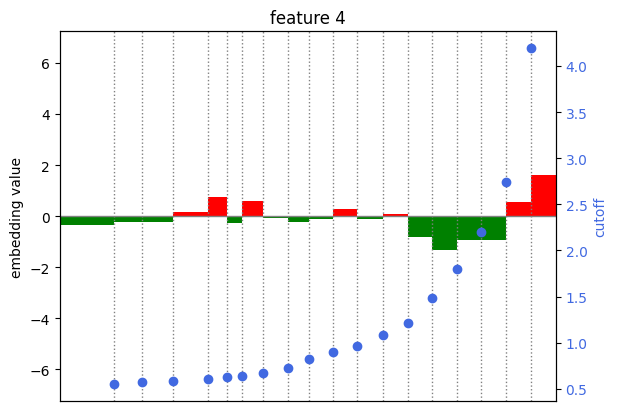

In [6]:
models['proposed model without step loss'].visualize(feature_names=X_train.columns, subset=['feature 4'])

# Regularization with step loss

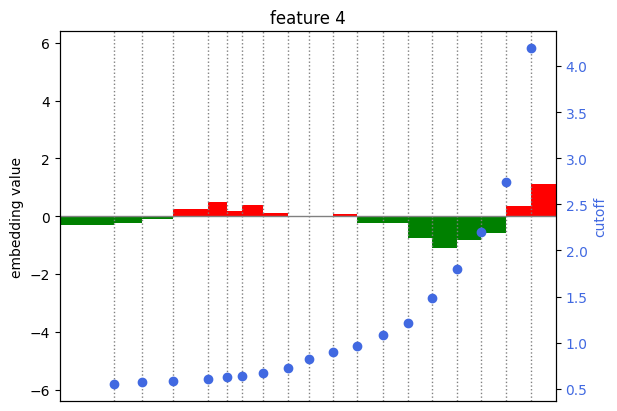

In [7]:
models['proposed model with step loss'].visualize(feature_names=X_train.columns, subset=['feature 4'])